In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import numpy as np

In [3]:
# Define hartree2kcalpermol

AVOGADROS_NUMBER = 6.022140857e23
HARTREE_TO_EV = 27.211386024367243
EV_TO_JOULE = 1.6021766208e-19
JOULE_TO_KCAL = 1 / 4184.0
HARTREE_TO_JOULE = HARTREE_TO_EV * EV_TO_JOULE
HARTREE_TO_KCALPERMOL = HARTREE_TO_JOULE * JOULE_TO_KCAL * AVOGADROS_NUMBER

def hartree2kcalpermol(x):
    r"""Hartree to kJ/mol conversion factor from CODATA 2014"""
    return x * HARTREE_TO_KCALPERMOL

In [4]:
df = pd.read_parquet('2x_1x-first_energies-forces_full.pq')

In [5]:
# Define atomic numbers for species of interest
atom_types = {1: "H", 6: "C", 7: "N", 8: "O"}

# Apply hartree2kcalpermol to data frame:
df["energy_mean"] = df["energy_mean"].apply(hartree2kcalpermol)
df["energy_qbc"] = df["energy_qbc"].apply(hartree2kcalpermol)
#df["dataset_energy"] = df["dataset_energy"].apply(hartree2kcalpermol)

df["atomic_energies"] = df["atomic_energies"].apply(lambda x: [hartree2kcalpermol(e) for e in x])
df["mean_atomic_energies"] = df["mean_atomic_energies"].apply(lambda x: [hartree2kcalpermol(e) for e in x])
df["stdev_atomic_energies"] = df["stdev_atomic_energies"].apply(lambda x: [hartree2kcalpermol(e) for e in x])

# Convert force magnitudes
df["force_magnitudes"] = df["force_magnitudes"].apply(lambda x: [hartree2kcalpermol(f) for f in x])
df["dataset_force_magnitudes"] = df["dataset_force_magnitudes"].apply(lambda x: [hartree2kcalpermol(f) for f in x])

print("All energies and forces converted to kcal/mol!")


All energies and forces converted to kcal/mol!


In [6]:
print(df.iloc[0])

id                                                              C10H10-0-idx0
species                     [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, ...
dataset_energy                                                    -386.884014
dataset_force_magnitudes    [87.38561144354274, 59.83847293938178, 47.3917...
energy_mean                                                    -242771.653475
energy_qbc                                                           0.092011
atomic_energies             [[8.044190375416068, 13.173256060783155, -9.28...
mean_atomic_energies        [10.127279965785181, 13.797642530509602, -7.53...
stdev_atomic_energies       [3.4873586621369865, 2.2769482476379324, 3.355...
force_magnitudes            [[89.54428448907721, 53.301169855057296, 48.18...
force_relative_stdev        [0.0247340127825737, 0.037792522460222244, 0.0...
force_relative_range        [0.06674791872501373, 0.12692676484584808, 0.0...
mean_relative_stdev                                             

In [7]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14
plt.rcParams["figure.figsize"] = (6.5, 4)
plt.rcParams["figure.dpi"] = 200

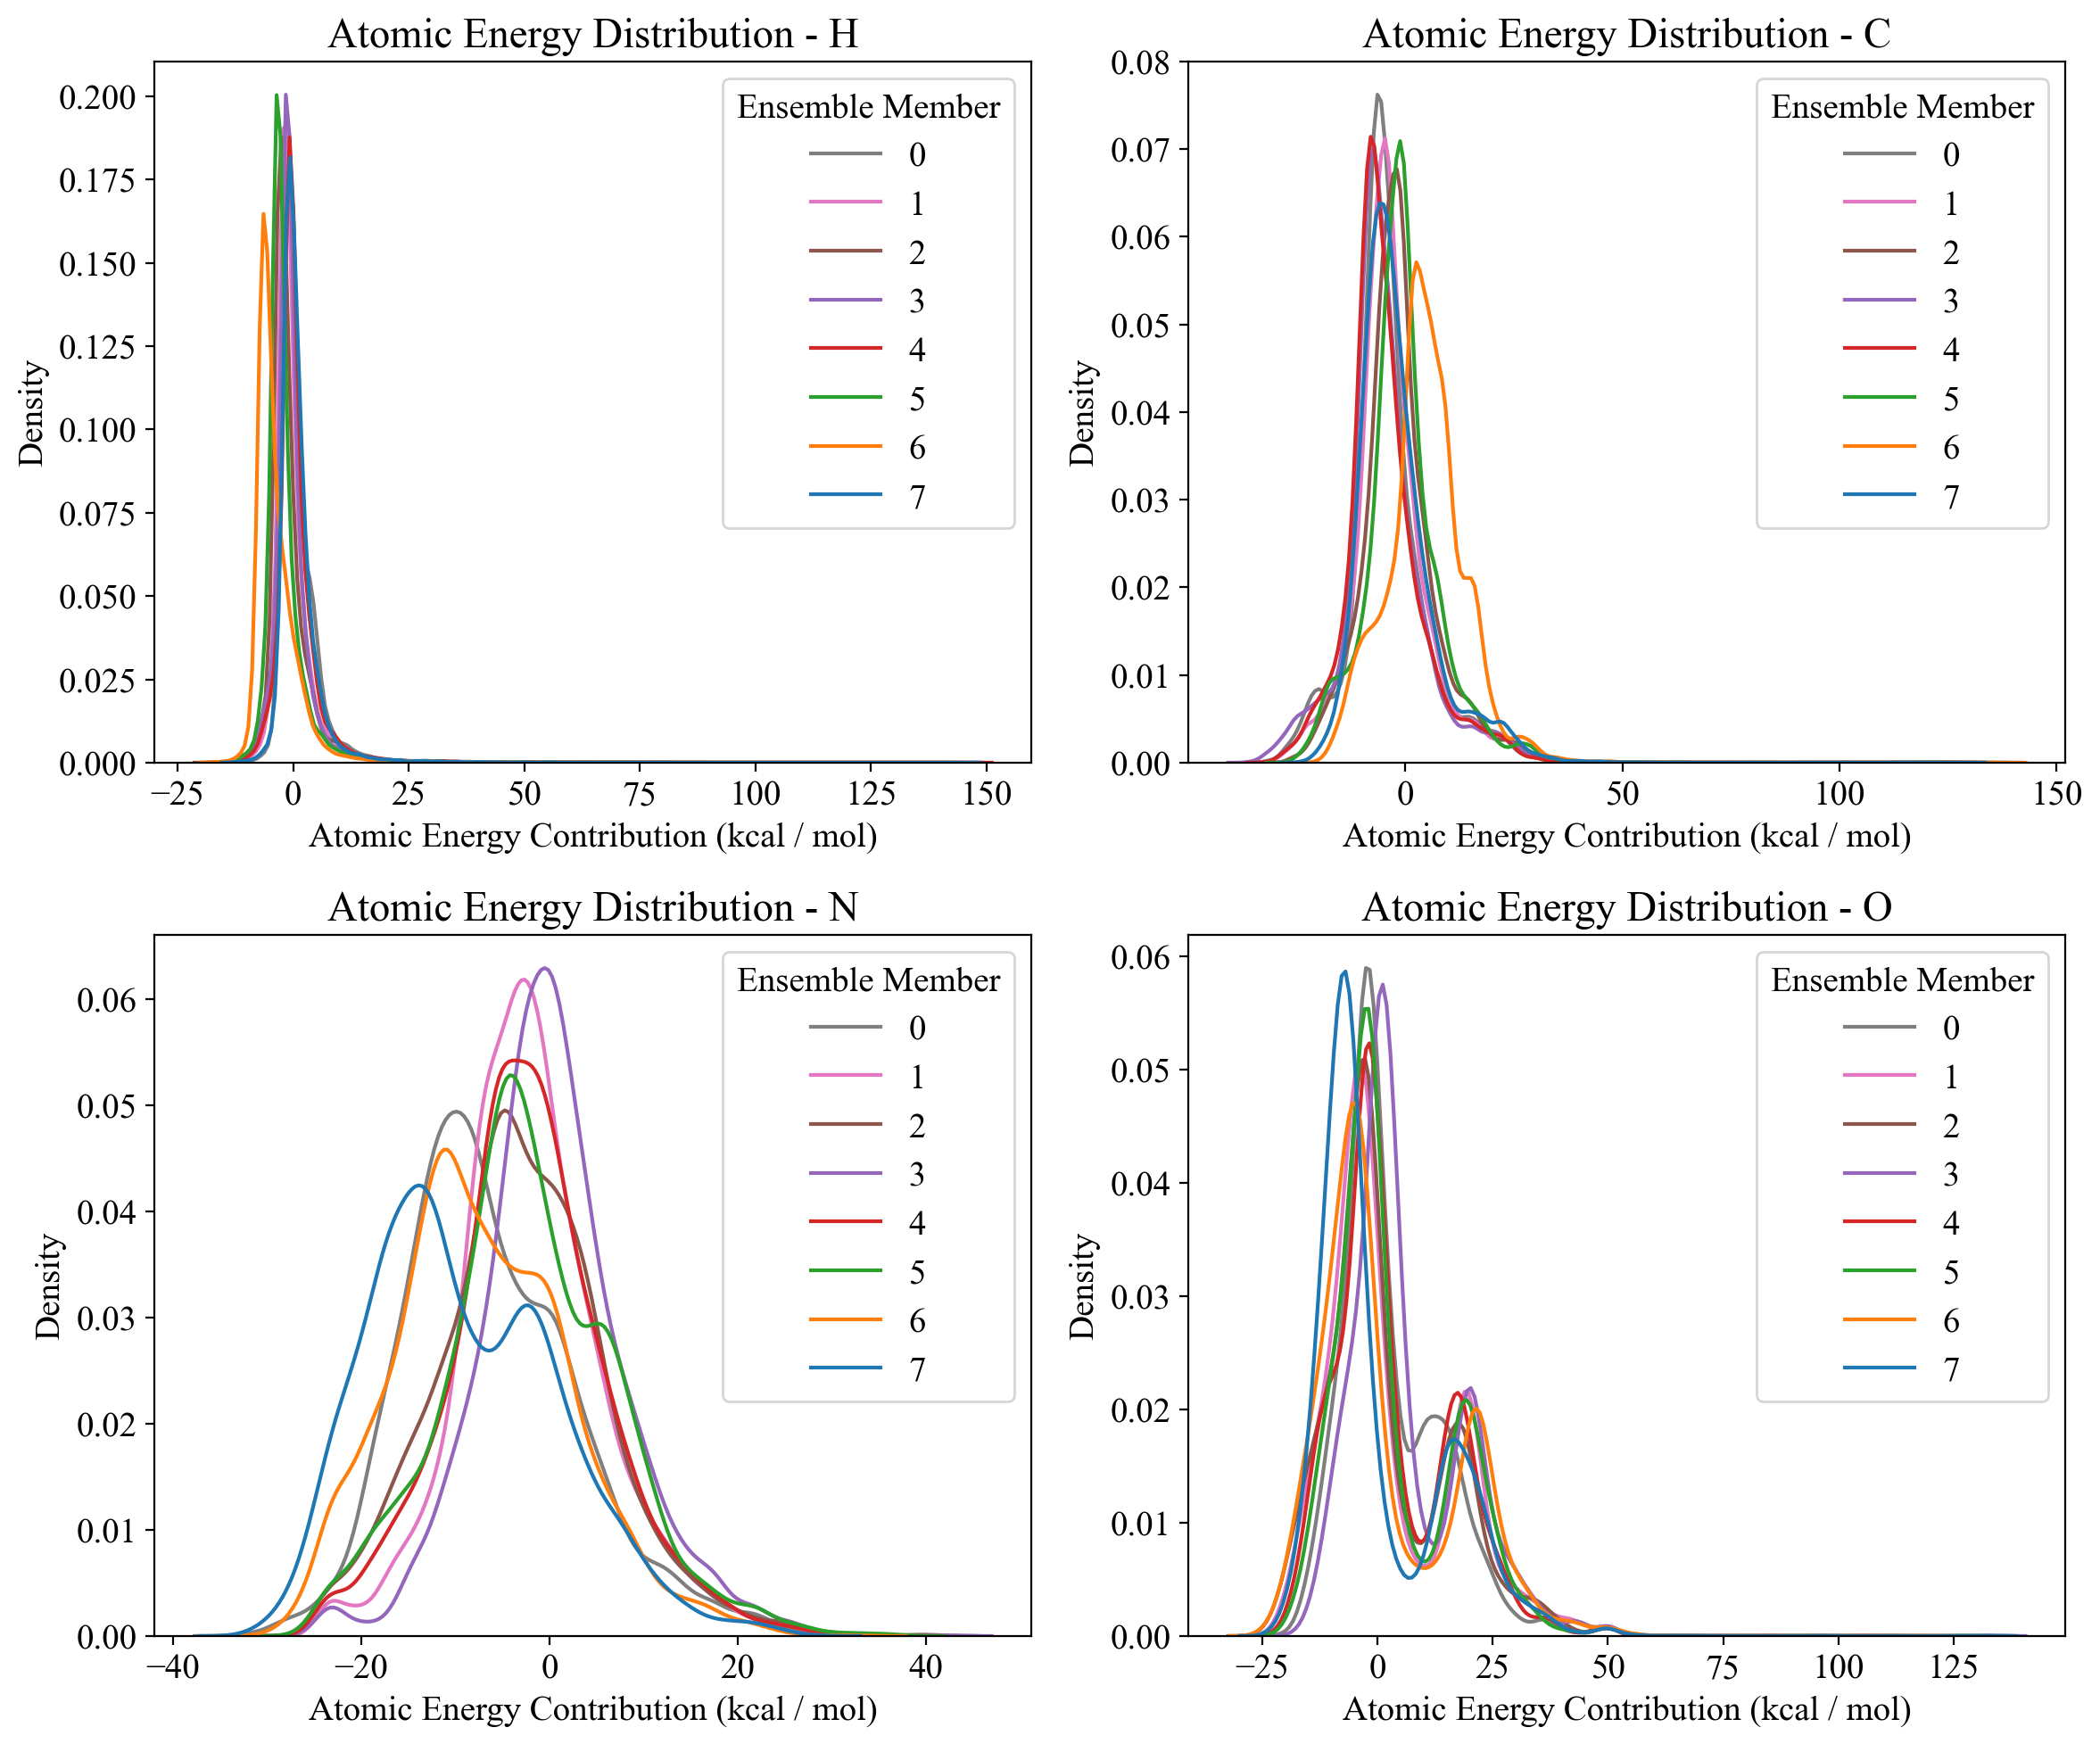

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

long_ae = []

for _, row in df.iterrows():
    species = row["species"]
    
    for i in range(8):  # 8 ensemble members
        atomic_energies = row["atomic_energies"][i]  # Shape [N_atoms]
        
        for atom_idx, energy in enumerate(atomic_energies):
            long_ae.append([row["id"], i, species[atom_idx], energy])


df_long_ae = pd.DataFrame(long_ae, columns=["id", "ensemble_member", "species", "atomic_energy"])


for idx, (atom_num, atom_name) in enumerate(atom_types.items()):
    ax = axes[idx]

    df_filtered = df_long_ae[df_long_ae["species"] == atom_num]

    sns.kdeplot(data=df_filtered, x="atomic_energy", hue="ensemble_member", ax=ax, palette="tab10", common_norm=False)
    ax.set_xlabel("Atomic Energy Contribution (kcal / mol)")
    ax.set_ylabel("Density")
    ax.set_title(f"Atomic Energy Distribution - {atom_name}")
    ax.legend(title="Ensemble Member", labels=df_long_ae["ensemble_member"].unique())

plt.tight_layout()

plt.savefig('./figures/2x_1x-first_ae-per-model.png')
plt.show()

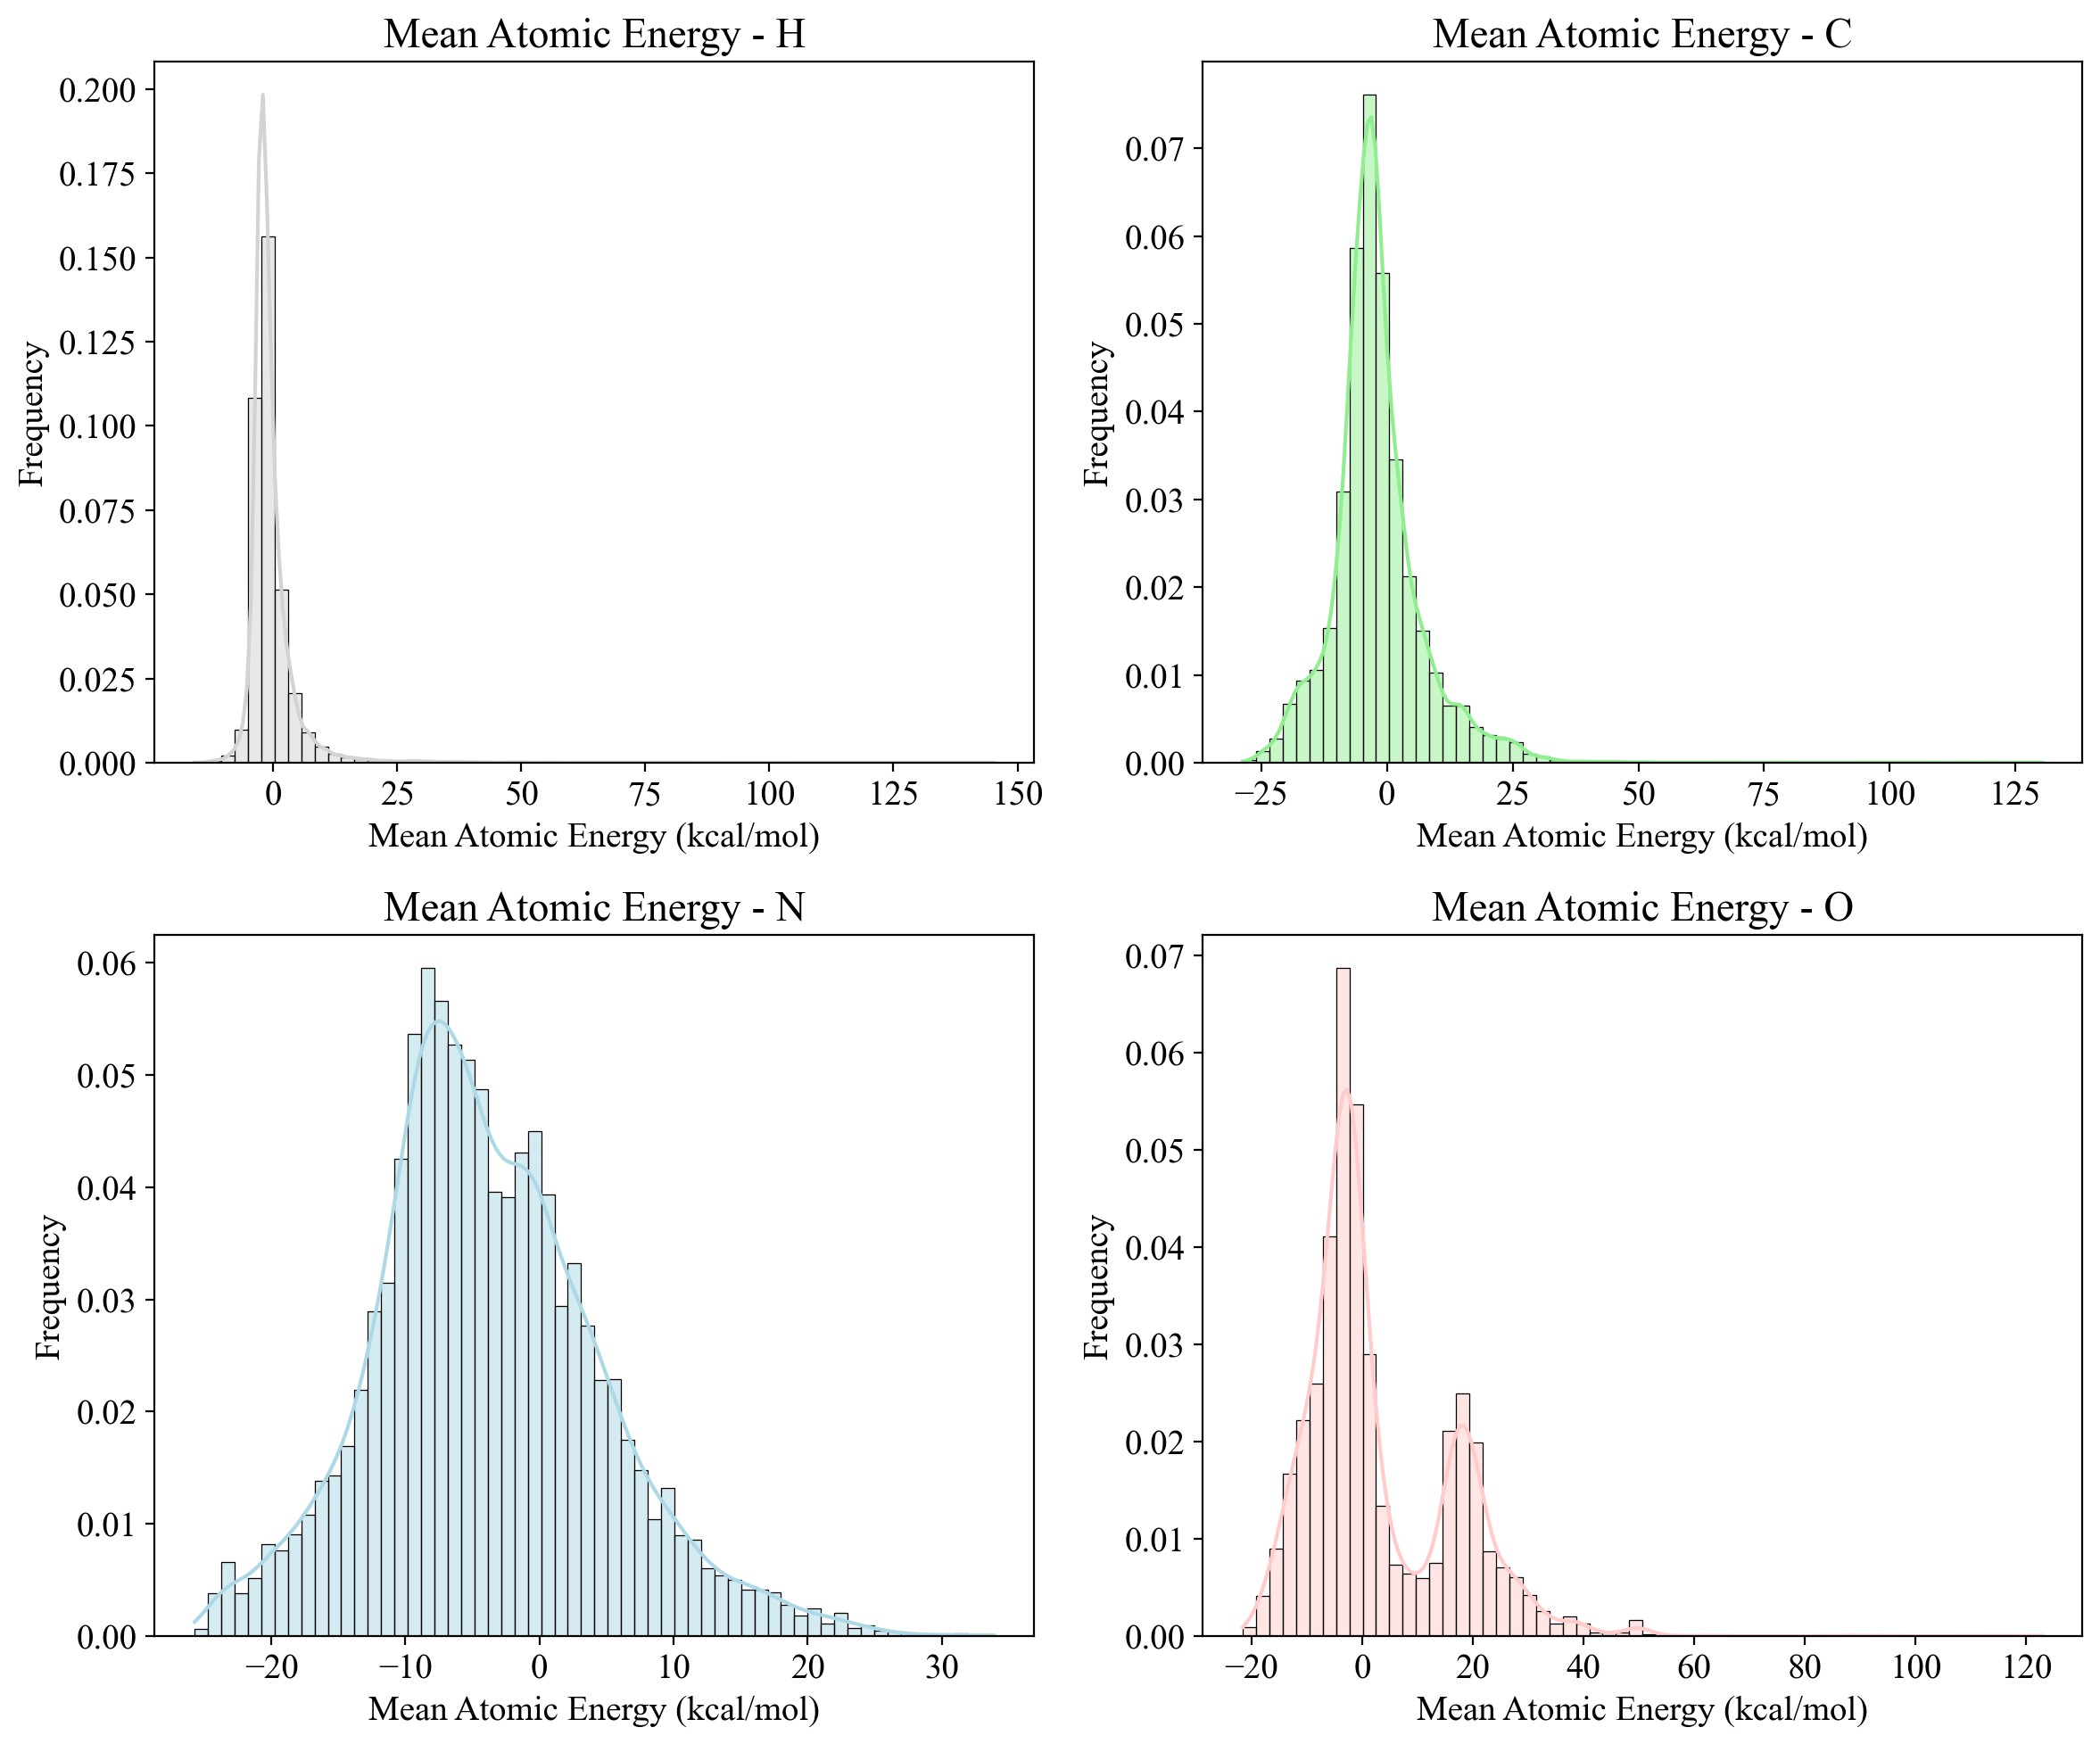

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define atomic numbers and corresponding colors
atom_types_colors = {
    1: ("H", "#d3d3d3"),   # Light Grey
    6: ("C", "#90ee90"),   # Light Green
    7: ("N", "#add8e6"),   # Light Blue
    8: ("O", "#ffcccb")    # Light Red
}

# Convert atomic energy lists into a long format DataFrame
long_ae = []
long_ae_stdev = []

for _, row in df.iterrows():
    species = row["species"]
    
    for atom_idx, (mean_energy, stdev_energy) in enumerate(zip(row["mean_atomic_energies"], row["stdev_atomic_energies"])):
        long_ae.append([row["id"], species[atom_idx], mean_energy])
        long_ae_stdev.append([row["id"], species[atom_idx], stdev_energy])

# Create DataFrames
df_long_ae = pd.DataFrame(long_ae, columns=["id", "species", "mean_atomic_energy"])
df_long_ae_stdev = pd.DataFrame(long_ae_stdev, columns=["id", "species", "stdev_atomic_energy"])

# Initialize subplots (2x2 layout) for Mean Atomic Energy
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Plot mean atomic energy histograms with custom colors
for idx, (atom_num, (atom_name, color)) in enumerate(atom_types_colors.items()):
    ax = axes[idx]
    
    # Filter dataset for the specific atom type
    df_filtered = df_long_ae[df_long_ae["species"] == atom_num]
    
    # Plot histogram
    sns.histplot(df_filtered["mean_atomic_energy"], bins=60, kde=True, ax=ax, color=color, stat='density')
    
    # Formatting
    ax.set_xlabel("Mean Atomic Energy (kcal/mol)")
    ax.set_ylabel("Frequency")
    ax.set_title(f"Mean Atomic Energy - {atom_name}")

# Adjust layout
plt.tight_layout()
plt.savefig('./figures/2x_1x-first_mean-ae-per-atomtype.png')
plt.show()



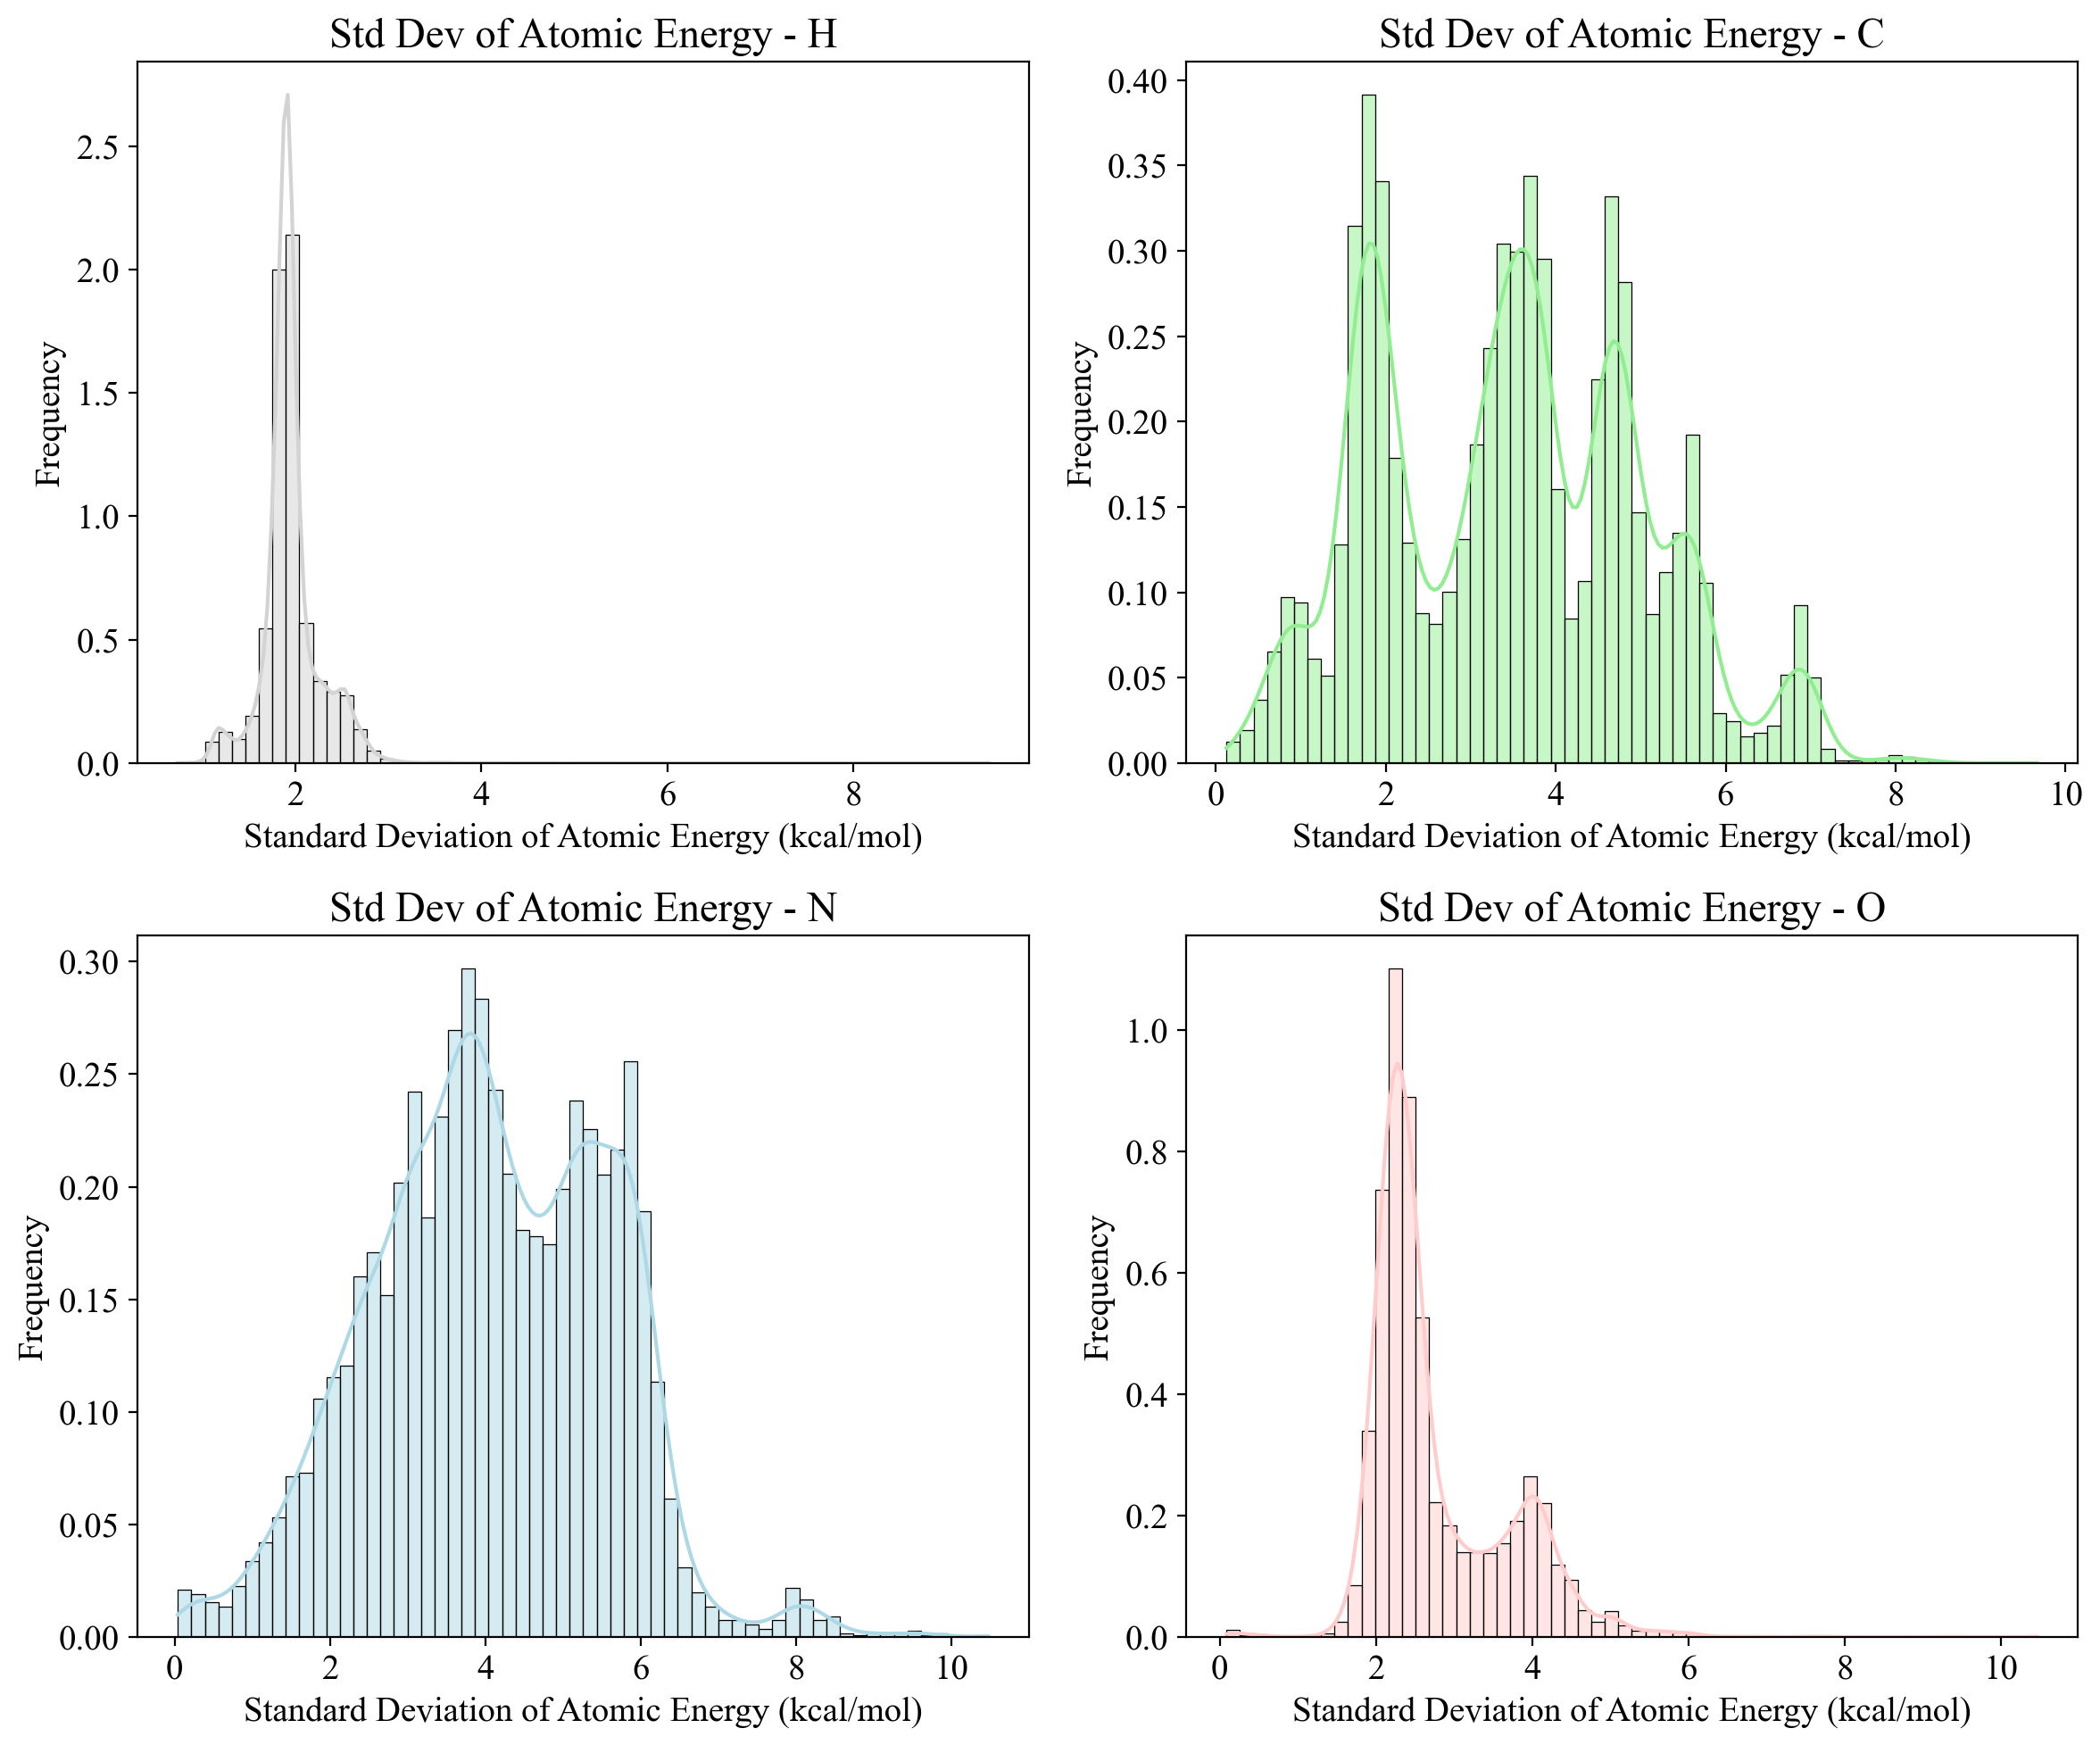

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, (atom_num, (atom_name, color)) in enumerate(atom_types_colors.items()):
    ax = axes[idx]
    
    df_filtered = df_long_ae_stdev[df_long_ae_stdev["species"] == atom_num]
    
    sns.histplot(df_filtered["stdev_atomic_energy"], bins=60, kde=True, ax=ax, color=color, stat='density')
    ax.set_xlabel("Standard Deviation of Atomic Energy (kcal/mol)")
    ax.set_ylabel("Frequency")
    ax.set_title(f"Std Dev of Atomic Energy - {atom_name}")

plt.tight_layout()
plt.savefig('./figures/2x_1x-first_stdev-ae-per-atomtype.png')
plt.show()



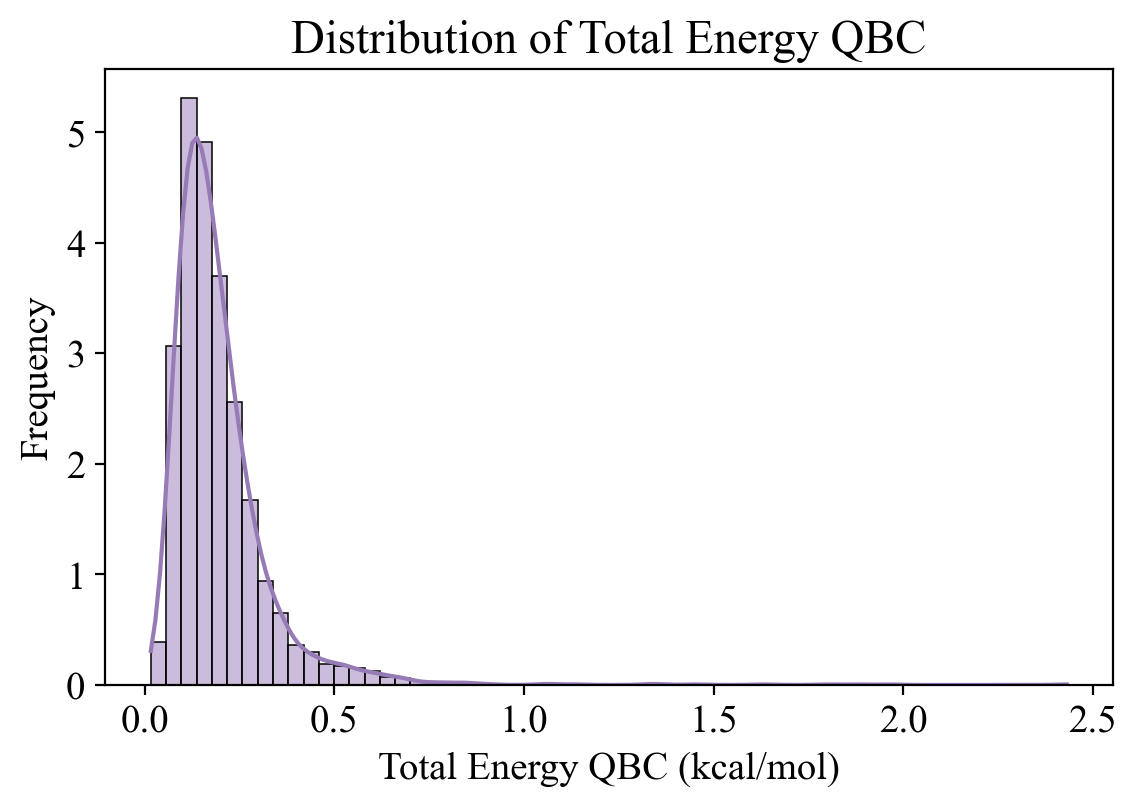

'\nLavender → #E6E6FA\nLilac → #C8A2C8\nSoft Pastel Purple → #D8BFD8\nMuted Purple → #B39EB5\nIf you want a slightly darker lavender/lilac:\n\nDeep Lilac → #967BB6\nDusty Purple → #9B7FB5\n'

In [14]:
# Histogram with KDE overlay
sns.histplot(df["energy_qbc"], bins=60, kde=True, color="#967BB6", edgecolor="black", stat='density')

# Labels and title
plt.xlabel("Total Energy QBC (kcal/mol)")
plt.ylabel("Frequency")
plt.title("Distribution of Total Energy QBC")
plt.savefig('./figures/2x_1x-first_total-e-qbc.png')

plt.show()

#For a lilac or lavender purple color, you can use these hex codes:
'''
Lavender → #E6E6FA
Lilac → #C8A2C8
Soft Pastel Purple → #D8BFD8
Muted Purple → #B39EB5
If you want a slightly darker lavender/lilac:

Deep Lilac → #967BB6
Dusty Purple → #9B7FB5
'''